<a href="https://colab.research.google.com/github/Jingi2103/Asia-Cup-2025---Cricket-Analysis/blob/main/crick_analysis_Asia_cup_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

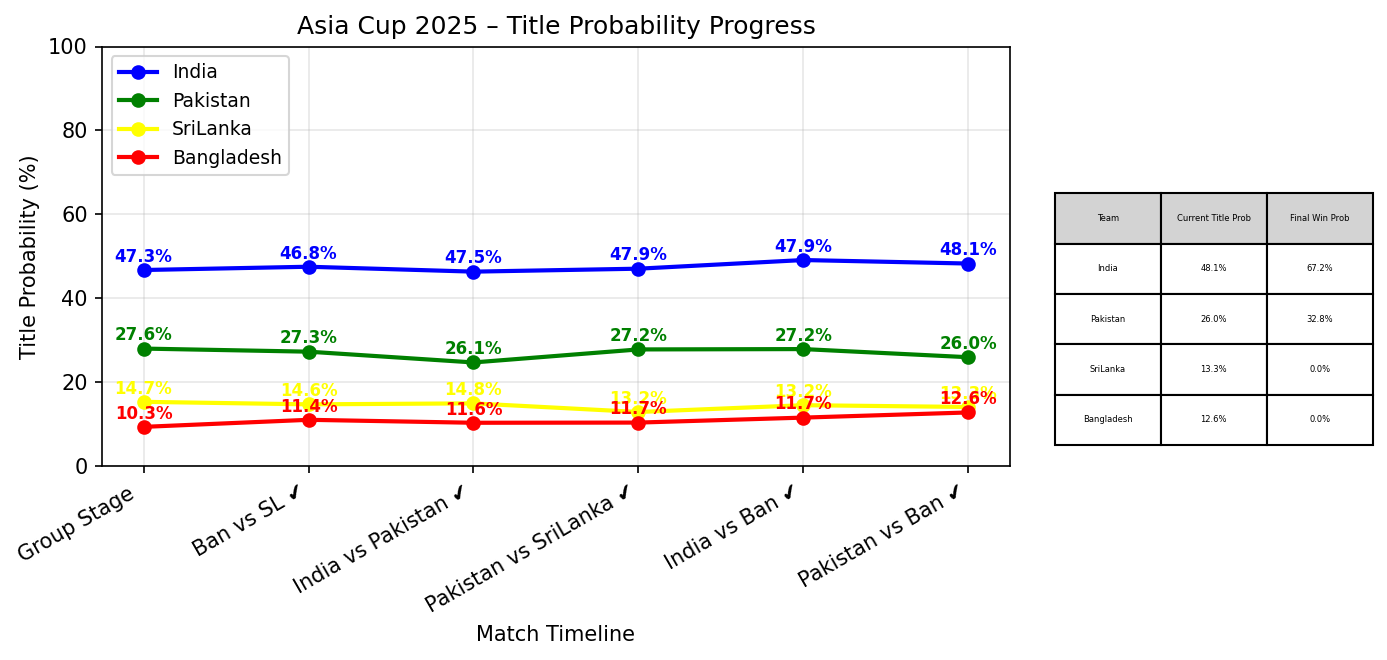

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1️⃣ Current team stats
# ---------------------------
teams = {
    "India":      {"wins": 5, "matches": 5, "nrr": 1.357, "chase_adv": 1, "defend_adv": 1},
    "Pakistan":   {"wins": 4, "matches": 6, "nrr": 0.329, "chase_adv": 1, "defend_adv": 0.6},
    "SriLanka":   {"wins": 3, "matches": 5, "nrr": -0.590, "chase_adv": 1, "defend_adv": 0},
    "Bangladesh": {"wins": 3, "matches": 6, "nrr": -0.831, "chase_adv": 0.5, "defend_adv": 0.5},
}

# Master timeline (all played matches so far)
timeline_labels = []

# Probability history (locked)
title_history = {t: [] for t in teams}

# ---------------------------
# 2️⃣ Compute base probabilities
# ---------------------------
def compute_probabilities(teams_dict):
    scores = {}
    for t, d in teams_dict.items():
        base = (d["wins"]/d["matches"])*0.6 + 0.4*(d["nrr"]+1.0)
        toss_factor = 0.5*d["chase_adv"] + 0.5*d["defend_adv"]
        scores[t] = max(0.01, base*(1 + 0.2*toss_factor))
    total = sum(scores.values())
    return {t: v/total for t,v in scores.items()}

# Initial snapshot
# Remove initial population of title_history and timeline_labels

# ---------------------------
# 3️⃣ Update function after each match
# ---------------------------
def update_after_match(match_name, winner=None):
    global teams, timeline_labels, title_history
    if winner:
        teams[winner]["wins"] += 1
        teams[winner]["matches"] += 1
        for t in teams:
            if t in match_name and t != winner:
                teams[t]["matches"] += 1
    timeline_labels.append(match_name)
    probs = compute_probabilities(teams)
    for t in teams:
        title_history[t].append(probs[t])

# match updates
update_after_match("Group Stage ")
update_after_match("Ban vs SL ✔", winner="Bangladesh")
update_after_match("India vs Pakistan ✔", winner="India")
update_after_match("Pakistan vs SriLanka ✔", winner="Pakistan")
update_after_match("India vs Ban ✔", winner="India")
update_after_match("Pakistan vs Ban ✔", winner="Bangladesh")



# ---------------------------
# 4️⃣ Plot with zigzag
# ---------------------------
plt.figure(figsize=(10,4.5), dpi=150)

colors = ['blue','green','yellow','red']

for idx, team in enumerate(teams):
    y_base = np.array(title_history[team])*100
    noise = np.random.uniform(-1.5,1.5,len(y_base))
    y_plot = np.clip(y_base + noise, 0, 100)
    plt.plot(range(len(timeline_labels)), y_plot, marker='o',
             color=colors[idx], linewidth=2, label=team)

    # Annotate every data point with locked probability
    for x, y, real_val in zip(range(len(timeline_labels)), y_plot, y_base):
        plt.text(x, y+1, f"{real_val:.1f}%", color=colors[idx],
                 fontsize=8, ha='center', va='bottom', fontweight='bold')

plt.title("Asia Cup 2025 – Title Probability Progress")
plt.xlabel("Match Timeline")
plt.ylabel("Title Probability (%)")
plt.xticks(range(len(timeline_labels)), timeline_labels, rotation=30, ha='right')
plt.ylim(0,100)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=9)

# Table for current title + final probability
table_data = []
for t in teams:
    final_prob = 0
    if t == t1:
        final_prob = final_win_prob_t1
    elif t == t2:
        final_prob = final_win_prob_t2
    table_data.append([t, f"{title_history[t][-1]*100:.1f}%", f"{final_prob*100:.1f}%"])

plt.table(
    cellText=table_data,
    colLabels=["Team","Current Title Prob","Final Win Prob"],
    cellLoc='center', colLoc='center',
    loc='right',
    bbox=[1.05, 0.05, 0.35, 0.6],
    cellColours=[['#ffffff','#ffffff','#ffffff'] for _ in table_data],  # white background
    colColours=['#d3d3d3','#d3d3d3','#d3d3d3'],  # light gray header
    edges='closed',
    fontsize=12
)

plt.tight_layout()
plt.show()